In [1]:
# Import libraries and data
import os
import numpy as np
import pickle

from src.utils.linear_regressor import perform_linear_regression
from config.settings import ROOT_DIR, saved_models_path
from src.utils.column_import import columns
s_x, s_y, v_x, v_y, a_x, a_y = columns


/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/inD/x_y_recording_00_range_384.csv
/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/scenario_samples/test_set/lane_merging_merged_dif_test.csv


# Acceleration Model (4 params)


Acceleration model with 4 parameters
\begin{align}
a(k-1) &= - \overline c_1 a(k)  + \overline c_2 \bigl( v(k+1) - v(k) \bigr) \\
a(k-1) &= - \overline c_3 a(k)  + \overline c_4 \bigl( s(k+1) - s(k) - dt \  v(k)\bigr)
\end{align}

Model in matrix notation
\begin{align}
    \begin{bmatrix}
        a(k-1) \\ a(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
         -a(k)  & v(k+1) - v(k)  & 0 & 0 \\
         0 & 0 & -a(k) &    s(k+1) - s(k) - dt \  v(k)
        \end{bmatrix}
        \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
    \end{bmatrix}
\end{align}

Add x and y components

\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)  & 0 & 0                   \\ 
        0 & 0 & -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)  & 0 & 0                   \\
        0 & 0 & -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}

For easier implementation split into two models

First model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_3 \\
   \end{bmatrix}
\end{align}



Second model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_2 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}



## Matrix creation
and same model 
but relative speed, position and acceleration

In [ ]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:



In [2]:
# Target vector y
y = np.concatenate([a_x[1:-1], a_y[1:-1]])    # a(k)
y.shape


(410546,)

In [3]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:

In [4]:
# Input features X_a of the first model
A = - a_x[0:-2]                
B = - a_y[0:-2]                
C = v_x[2:] - v_x[1:-1]        
D = v_y[2:] - v_y[1:-1]        

X_a = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_a


array([[ 0.01047,  0.00038],
       [ 0.01211,  0.0008 ],
       [ 0.01427,  0.0009 ],
       ...,
       [ 0.19391, -0.00808],
       [ 0.19445, -0.00788],
       [ 0.19465, -0.00779]])

In [9]:
X_a.shape

(410546, 2)

In [5]:
# Input features X_b of the second model
dt = 0.04
A = - a_x[0:-2]                                 
B = - a_y[0:-2]                                 
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        

X_b = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_b

array([[ 0.01047  , -0.0017524],
       [ 0.01211  , -0.0012776],
       [ 0.01427  , -0.0005896],
       ...,
       [ 0.19391  , -0.0008416],
       [ 0.19445  , -0.0006984],
       [ 0.19465  , -0.0003832]])

## Perform Regression

Mean Squared Error (MSE): 3.3551e-03
Mean Absolute Error (MAE): 1.1833e-02
R-squared (R²) Score: 9.8982e-01
Coefficients:
-0.9952219042872908
0.0004375584277085994


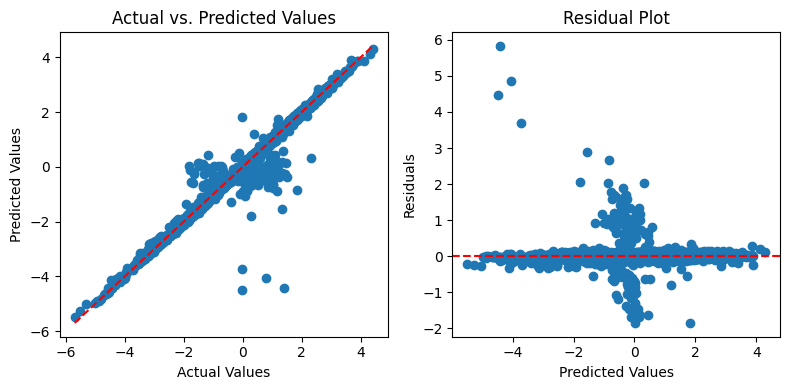

In [6]:
# First model
first_model = perform_linear_regression(X_a, y)


Mean Squared Error (MSE): 3.3552e-03
Mean Absolute Error (MAE): 1.1826e-02
R-squared (R²) Score: 9.8982e-01
Coefficients:
-0.9952386680963472
2.848228071024513e-07


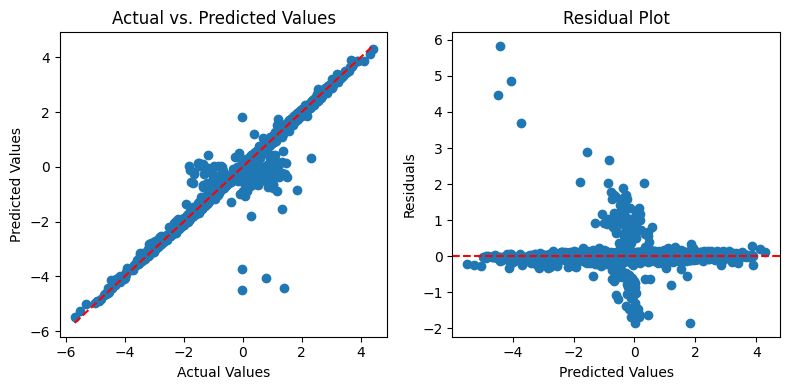

In [7]:
# Second model
second_model = perform_linear_regression(X_b, y)

In [8]:
# Save both models in a pickle file
def save_model(model, model_name):
    model_file_path = os.path.join(saved_models_path, f'acceleration_model_4/{model_name}.pkl')
    
    with open(model_file_path, 'wb') as file:
        pickle.dump(model, file)
    
    print(f'Model "{model_name}" saved to: {model_file_path}')

save_model(first_model, 'first_model')
save_model(second_model, 'second_model')



Model "first_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/first_model.pkl
Model "second_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/second_model.pkl
